## Capstone Project Codes

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
import json 
import requests
from pandas.io.json import json_normalize 

---
## Import Edmonton data and wrangle
---
We import demographic data of Edmonton and sum across to get total population for each neighbourhood


In [2]:
Edmonton = pd.read_csv("2016_Census_-_Population_by_Age_Range__Neighbourhood_Ward_.csv")
Edmonton.drop('Ward', axis=1, inplace=True)
Edmonton['Population']=Edmonton.iloc[:,2:].sum(axis=1)
Edmonton.drop(Edmonton.iloc[:,2:21], axis=1, inplace=True)
print(Edmonton.shape)
Edmonton.head()

(388, 3)


,Neighbourhood Number,Neighbourhood Name,Population
0,3140,CRESTWOOD,1129
1,3330,PARKVIEW,1764
2,6110,CPR IRVINE,12
3,5350,RHATIGAN RIDGE,1399
4,4140,ELMWOOD,1506


We read into pandas the Neighbourhood location and area size for further analysis

In [3]:
Ed_loc = pd.read_csv('City_of_Edmonton_-_Neighbourhoods__Centroid_Point_.csv')
print(Ed_loc.shape)
Ed_loc.head()

(401, 6)


,Neighbourhood Number,Neighbourhood Name,Area Sq Km,Latitude,Longitude,Location
0,4150,Gagnon Estate Industrial,0.556701,53.580184,-113.585795,"(53.58018417365767, -113.58579493909596)"
1,6390,Larkspur,1.658195,53.480210,-113.381240,"(53.4802104573005, -113.38123994870551)"
2,4440,River Valley Lessard North,0.794190,53.504195,-113.584827,"(53.504195315820766, -113.58482693803155)"
3,2462,Crystallina Nera East,0.858689,53.640784,-113.448768,"(53.64078411972238, -113.44876804405544)"
4,5060,Blue Quill,1.058050,53.457627,-113.526237,"(53.45762652276185, -113.52623651519588)"


We again read crime data into pandas which is made up of occurence of crime from 2009 to 2019. To get the total sum of crimes in each neighbourhood, we sum occurence by neighborhoods.

In [4]:
Ed_crime = pd.read_csv('EPS_Neighbourhood_Criminal_Occurrences.csv')
Ed_crime.drop(Ed_crime.iloc[:,1:5], axis=1, inplace=True)
Ed_crime = Ed_crime.groupby('Neighbourhood Description (Occurrence)').sum()
Ed_crime.rename(columns={'Neighbourhood Description (Occurrence)':'Neighbourhood Name_x'})
Ed_crime.reset_index(inplace=True) 
print(Ed_crime.shape)
Ed_crime.head()

(393, 2)


,Neighbourhood Description (Occurrence),# Occurrences
0,ABBOTTSFIELD,976
1,ALBANY,221
2,ALBERTA AVENUE,5048
3,ALBERTA PARK INDUSTRIAL,260
4,ALDERGROVE,937


In [5]:
Ed_crime.to_csv('Ed_crime.csv', index=False)

We editted the crime data to match neighbourhood names and reimported

In [6]:
Ed_crime = pd.read_csv('Ed_crime_edit.csv')
print(Ed_crime.shape)
Ed_crime.head()

(382, 3)


,Neighbourhood Description (Occurrence),Neighbourhood Name_y,# Occurrences
0,ABBOTTSFIELD,Abbottsfield,976.0
1,ALBANY,Albany,221.0
2,ALBERTA AVENUE,Alberta Avenue,5048.0
3,ALBERTA PARK INDUSTRIAL,Alberta Park Industrial,260.0
4,ALDERGROVE,Aldergrove,937.0


Now, we merge Edmonton data to our location data

In [7]:
Ed = pd.merge(Edmonton, Ed_loc, on = 'Neighbourhood Number')
print(Ed.shape)
Ed.head()

(382, 8)


,Neighbourhood Number,Neighbourhood Name_x,Population,Neighbourhood Name_y,Area Sq Km,Latitude,Longitude,Location
0,3140,CRESTWOOD,1129,Crestwood,1.168158,53.535434,-113.569038,"(53.53543354829023, -113.56903784940349)"
1,3330,PARKVIEW,1764,Parkview,1.546448,53.524060,-113.567914,"(53.524060365765735, -113.56791414354251)"
2,6110,CPR IRVINE,12,CPR Irvine,0.663610,53.507527,-113.490549,"(53.50752668934572, -113.4905491361979)"
3,5350,RHATIGAN RIDGE,1399,Rhatigan Ridge,1.344078,53.474506,-113.587569,"(53.474506145469945, -113.5875691214093)"
4,4140,ELMWOOD,1506,Elmwood,1.025925,53.515738,-113.605993,"(53.515738255461834, -113.60599332906781)"


We now sort our data by neighbourhood names from A to Z in order to match the crime data for merging

In [8]:
Ed_merge = pd.merge(Ed, Ed_crime, on='Neighbourhood Name_y')
Ed_merge['Population density'] = Ed_merge['Population']/Ed_merge['Area Sq Km']
Ed_merge.rename(columns={'Neighbourhood Name_y':'Neighborhood', '# Occurrences':'Crimes'}, inplace=True)
first_column = Ed_merge.pop('Neighborhood')
Ed_merge.insert(0, 'Neighborhood',first_column)
print(Ed_merge.shape)
Ed_merge.head()

(382, 11)


,Neighborhood,Neighbourhood Number,Neighbourhood Name_x,Population,Area Sq Km,Latitude,Longitude,Location,Neighbourhood Description (Occurrence),Crimes,Population density
0,Crestwood,3140,CRESTWOOD,1129,1.168158,53.535434,-113.569038,"(53.53543354829023, -113.56903784940349)",CRESTWOOD,566.0,966.478990
1,Parkview,3330,PARKVIEW,1764,1.546448,53.524060,-113.567914,"(53.524060365765735, -113.56791414354251)",PARKVIEW,564.0,1140.678328
2,CPR Irvine,6110,CPR IRVINE,12,0.663610,53.507527,-113.490549,"(53.50752668934572, -113.4905491361979)",CAERNARVON,1073.0,18.082917
3,Rhatigan Ridge,5350,RHATIGAN RIDGE,1399,1.344078,53.474506,-113.587569,"(53.474506145469945, -113.5875691214093)",RHATIGAN RIDGE,194.0,1040.862586
4,Elmwood,4140,ELMWOOD,1506,1.025925,53.515738,-113.605993,"(53.515738255461834, -113.60599332906781)",ELMWOOD,426.0,1467.943293


We drop columns that we don't need for data to look clean 

In [9]:
Ed_merge.drop(Ed_merge[['Location','Neighbourhood Description (Occurrence)', 'Neighbourhood Name_x', 
                        'Neighbourhood Number', 'Population','Area Sq Km']], 
              axis=1, inplace=True)
print(Ed_merge.shape)
Ed_merge.head()

(382, 5)


,Neighborhood,Latitude,Longitude,Crimes,Population density
0,Crestwood,53.535434,-113.569038,566.0,966.478990
1,Parkview,53.524060,-113.567914,564.0,1140.678328
2,CPR Irvine,53.507527,-113.490549,1073.0,18.082917
3,Rhatigan Ridge,53.474506,-113.587569,194.0,1040.862586
4,Elmwood,53.515738,-113.605993,426.0,1467.943293


Replace missing crime values with mean crime

In [10]:
avg_crimes = Ed_merge['Crimes'].astype('float').mean(axis=0)
Ed_merge['Crimes'].replace(0, avg_crimes, inplace=True)

We need only neighbourhoods with population density greater than the mean 

In [11]:
avg_popdensity = Ed_merge['Population density'].astype('float').mean(axis=0)
Ed_merge = Ed_merge.drop(Ed_merge[Ed_merge['Population density'] < avg_popdensity].index)
Ed_merge.reset_index(inplace=True) 

In [12]:
Ed_merge.drop(Ed_merge[['index']], axis=1, inplace=True)
print(Ed_merge.shape)
Ed_merge.head()

(212, 5)


,Neighborhood,Latitude,Longitude,Crimes,Population density
0,Crestwood,53.535434,-113.569038,566.0,966.478990
1,Parkview,53.524060,-113.567914,564.0,1140.678328
2,Rhatigan Ridge,53.474506,-113.587569,194.0,1040.862586
3,Elmwood,53.515738,-113.605993,426.0,1467.943293
4,Kenilworth,53.521633,-113.431042,690.0,1599.592365


---
## Explore Edmonton data from Foursquare 
---

In [13]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

In [14]:
address = 'Edmonton, CA'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of City of Edmonton are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of City of Edmonton are 53.535411, -113.507996.


In [15]:
map_edmonton = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(Ed_merge['Latitude'], Ed_merge['Longitude'], Ed_merge['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_edmonton)  
    
map_edmonton

CLIENT_ID = '20JLQJBNKH11AAA5BIBTYNA0RDPE3KEA4HXECE3HWJP5FXMT'
CLIENT_SECRET = 'TQAMRLS3ON1JOH2A1WXT4XYQY200Z3MYBVDBMMBSOS0TTBNS'
VERSION = '20200701'

print('Your credentails: RA')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [16]:
CLIENT_ID = 'IQYARPTUE4BDLE1Y4CEW1PYMDL0WBTHBP3CJ4ICBR5W5JRZL'
CLIENT_SECRET = '4F1RTI1O3FJCBLLD42SYNDSQSJIBNARILM5O32DKUCWWCDC3'
VERSION = '20200701'

print('Your credentails: RA')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails: RA
CLIENT_ID: IQYARPTUE4BDLE1Y4CEW1PYMDL0WBTHBP3CJ4ICBR5W5JRZL
CLIENT_SECRET:4F1RTI1O3FJCBLLD42SYNDSQSJIBNARILM5O32DKUCWWCDC3


CLIENT_ID = 'FPHMXME324HLWO2KEL4HB3BCVUHP21PYI52JP0Q5V0SOXQWS'
CLIENT_SECRET = 'ZTR3CGSE1Q04V01VQKOUFFD1Y0W4T0S1JUS1GNECLROPHYPA'
VERSION = '20200701'

print('Your credentails: RA')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

# **This is where I suppose the error comes from**

In [17]:
categoryid = "4d4b7105d754a06372d81259,52f2ab2ebcbc57f1066b8b46,4bf58dd8d48988d13d941735,\
52f2ab2ebcbc57f1066b8b4f,4bf58dd8d48988d1fc931735,4bf58dd8d48988d196941735,52e81612bcbc57f1066b7a26"

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000,limit=200,categoryId=categoryid):
    """This function generates a maximum of 200 venues within 10,000 radius of each neighbour.
    It uses the Foursquare API.
    """
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
Edmonton_venues = getNearbyVenues(names=Ed_merge['Neighborhood'],
                                   latitudes=Ed_merge['Latitude'],
                                   longitudes=Ed_merge['Longitude']
                                  )

Crestwood
Parkview
Rhatigan Ridge
Elmwood
Kenilworth
Brintnell
Evergreen
Alberta Avenue
Crawford Plains
La Perle
Rundle Heights
Tawa
Downtown
Menisa
Overlanders
Thorncliff
Capilano
Callingwood South
Richfield
Belvedere
Daly Grove
Queen Alexandra
Silver Berry
Lymburn
Blackmud Creek
Rosslyn
Delton
Elsinore
Highlands
Rutherford
Kernohan
Steinhauer
Weinlos
Blackburne
Carter Crest
McCauley
Abbottsfield
Lee Ridge
Eastwood
Skyrattler
Westmount
Haddow
Woodcroft
Ozerna
Aspen Gardens
Klarvatten
Sweet Grass
Glengarry
Grovenor
Baturyn
Breckenridge Greens
Holyrood
Lorelei
Beverly Heights
North Glenora
Pollard Meadows
Calder
Hodgson
Avonmore
Bonnie Doon
Hollick-Kenyon
Ermineskin
Larkspur
Blue Quill Estates
Evansdale
Westwood
Mayfield
Matt Berry
Canon Ridge
Callingwood North
York
Oleskiw
Kirkness
McQueen
Chambery
Dunluce
Mill Woods Town Centre
Bannerman
Lendrum Place
Sakaw
Lago Lindo
Royal Gardens
Ritchie
Keheewin
Athlone
Garneau
Fulton Place
Casselman
Pleasantview
Allendale
Beacon Heights
Sifton Par

Get unique neighborhood Venues

In [20]:
Categories=Edmonton_venues['Venue Category'].unique()
print(Categories)

['Grocery Store' 'Supermarket' 'High School' 'Light Rail Station'
 'Hospital' 'Medical Center' 'Factory' 'Pharmacy' 'Emergency Room'
 'Train Station' 'Big Box Store' 'Bus Station' 'Recreation Center'
 'College & University' 'University' 'College Academic Building'
 'General College & University' 'College Science Building'
 'Student Center' 'Community College' 'College Gym'
 'College Administrative Building' 'Medical School' 'Trade School'
 'College Residence Hall' 'College Arts Building'
 'College Engineering Building' 'College Library' 'Fraternity House'
 'College Theater' 'College Cafeteria' 'College Quad' 'Library'
 'College Classroom' 'College Bookstore' 'College Rec Center'
 'College Stadium' 'College Technology Building' 'Pub' 'Mini Golf']


In [21]:
Edmonton_venues.to_csv('Edmonton Venues.csv', index=False)

Analyze Each NeighborhoodGroup rows by neighborhood and take the mean frequency of occurrence of each category

In [22]:
# one hot encoding
Edmonton_onehot = pd.get_dummies(Edmonton_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Edmonton_onehot['Neighborhood'] = Edmonton_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Edmonton_onehot.columns[-1]] + list(Edmonton_onehot.columns[:-1])
Edmonton_onehot = Edmonton_onehot[fixed_columns]
print(Edmonton_onehot.shape)
Edmonton_onehot.head()

(17881, 41)


,Neighborhood,Big Box Store,Bus Station,College & University,College Academic Building,College Administrative Building,College Arts Building,College Bookstore,College Cafeteria,College Classroom,...,Medical School,Mini Golf,Pharmacy,Pub,Recreation Center,Student Center,Supermarket,Trade School,Train Station,University
0,Crestwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Crestwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Crestwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Crestwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Crestwood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [23]:
print(Edmonton_venues.shape)
Edmonton_venues.head()

(17881, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crestwood,53.535434,-113.569038,IGA Andy's Valleyview,53.525746,-113.566761,Grocery Store
1,Crestwood,53.535434,-113.569038,Save-On-Foods,53.542695,-113.508737,Supermarket
2,Crestwood,53.535434,-113.569038,T&T Supermarket,53.523360,-113.623934,Supermarket
3,Crestwood,53.535434,-113.569038,Safeway Oliver,53.547432,-113.518189,Grocery Store
4,Crestwood,53.535434,-113.569038,Safeway Canada,53.559390,-113.553442,Supermarket


Group rows by neighborhood and take the mean frequency of occurrence of each category

In [24]:
Edmonton_grouped = Edmonton_onehot.groupby('Neighborhood').mean().reset_index()
Edmonton_grouped

,Neighborhood,Big Box Store,Bus Station,College & University,College Academic Building,College Administrative Building,College Arts Building,College Bookstore,College Cafeteria,College Classroom,...,Medical School,Mini Golf,Pharmacy,Pub,Recreation Center,Student Center,Supermarket,Trade School,Train Station,University
0,Abbottsfield,0.069444,0.013889,0.013889,0.041667,0.013889,0.000000,0.0,0.027778,0.0,...,0.027778,0.0,0.027778,0.0,0.027778,0.013889,0.083333,0.027778,0.013889,0.013889
1,Alberta Avenue,0.060000,0.010000,0.010000,0.090000,0.020000,0.000000,0.0,0.000000,0.0,...,0.020000,0.0,0.030000,0.0,0.020000,0.020000,0.090000,0.020000,0.010000,0.030000
2,Aldergrove,0.033333,0.000000,0.000000,0.100000,0.044444,0.022222,0.0,0.022222,0.0,...,0.044444,0.0,0.033333,0.0,0.000000,0.022222,0.044444,0.000000,0.011111,0.033333
3,Allendale,0.050000,0.010000,0.010000,0.070000,0.030000,0.010000,0.0,0.000000,0.0,...,0.040000,0.0,0.030000,0.0,0.000000,0.020000,0.060000,0.030000,0.010000,0.030000
4,Argyll,0.070000,0.010000,0.010000,0.070000,0.030000,0.010000,0.0,0.000000,0.0,...,0.040000,0.0,0.020000,0.0,0.010000,0.020000,0.060000,0.030000,0.010000,0.030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,Westridge,0.040000,0.010000,0.000000,0.080000,0.040000,0.020000,0.0,0.000000,0.0,...,0.040000,0.0,0.040000,0.0,0.000000,0.020000,0.040000,0.010000,0.010000,0.030000
208,Westwood,0.060000,0.010000,0.010000,0.090000,0.020000,0.000000,0.0,0.000000,0.0,...,0.030000,0.0,0.030000,0.0,0.020000,0.020000,0.090000,0.020000,0.010000,0.030000
209,Wild Rose,0.113636,0.000000,0.022727,0.000000,0.022727,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.022727,0.0,0.022727,0.000000,0.045455,0.045455,0.000000,0.000000
210,Woodcroft,0.050000,0.010000,0.010000,0.070000,0.020000,0.000000,0.0,0.000000,0.0,...,0.030000,0.0,0.040000,0.0,0.010000,0.020000,0.110000,0.010000,0.010000,0.030000


Create dataframe for each neighbourhood with top venues

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Edmonton_grouped['Neighborhood']

for ind in np.arange(Edmonton_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Edmonton_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbottsfield,Grocery Store,Hospital,Light Rail Station,Supermarket,Community College,High School,Big Box Store,College Academic Building,Pharmacy,Medical School
1,Alberta Avenue,Grocery Store,Light Rail Station,Hospital,College Academic Building,Supermarket,Big Box Store,High School,Community College,University,Pharmacy
2,Aldergrove,Grocery Store,College Academic Building,Hospital,Light Rail Station,High School,Supermarket,College Administrative Building,Medical School,University,College Gym
3,Allendale,Grocery Store,Hospital,Light Rail Station,College Academic Building,High School,Supermarket,Big Box Store,Medical School,College Administrative Building,General College & University
4,Argyll,Grocery Store,Hospital,Light Rail Station,Big Box Store,College Academic Building,High School,Supermarket,Medical School,College Administrative Building,General College & University


---
## Model 
---

Cluster using K-Means Algorithm

In [26]:
#Drop Neighborhood for clustering
Edmonton_grouped_clustering = Edmonton_grouped.drop('Neighborhood', 1)
Edmonton_grouped_clustering.head()

,Big Box Store,Bus Station,College & University,College Academic Building,College Administrative Building,College Arts Building,College Bookstore,College Cafeteria,College Classroom,College Engineering Building,...,Medical School,Mini Golf,Pharmacy,Pub,Recreation Center,Student Center,Supermarket,Trade School,Train Station,University
0,0.069444,0.013889,0.013889,0.041667,0.013889,0.000000,0.0,0.027778,0.0,0.013889,...,0.027778,0.0,0.027778,0.0,0.027778,0.013889,0.083333,0.027778,0.013889,0.013889
1,0.060000,0.010000,0.010000,0.090000,0.020000,0.000000,0.0,0.000000,0.0,0.000000,...,0.020000,0.0,0.030000,0.0,0.020000,0.020000,0.090000,0.020000,0.010000,0.030000
2,0.033333,0.000000,0.000000,0.100000,0.044444,0.022222,0.0,0.022222,0.0,0.011111,...,0.044444,0.0,0.033333,0.0,0.000000,0.022222,0.044444,0.000000,0.011111,0.033333
3,0.050000,0.010000,0.010000,0.070000,0.030000,0.010000,0.0,0.000000,0.0,0.000000,...,0.040000,0.0,0.030000,0.0,0.000000,0.020000,0.060000,0.030000,0.010000,0.030000
4,0.070000,0.010000,0.010000,0.070000,0.030000,0.010000,0.0,0.000000,0.0,0.000000,...,0.040000,0.0,0.020000,0.0,0.010000,0.020000,0.060000,0.030000,0.010000,0.030000


Determining the number of Clusters to use with the Elbow method

In [27]:
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Edmonton_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

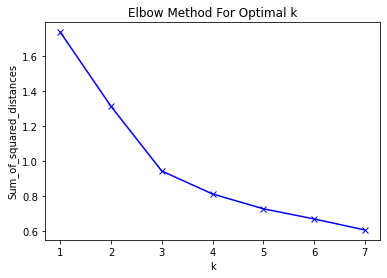

In [28]:
#Visualising the Elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Edmonton_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 0, 0, 2, 0, 0, 0, 0], dtype=int32)

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Ed_cluster = Ed_merge

# merge Edmonton_grouped with Ed_merge to add latitude/longitude for each neighborhood
Ed_cluster = Ed_cluster.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#Drop row with missing cluster values
Ed_cluster=Ed_cluster.dropna(subset=['Cluster Labels'])
Ed_cluster['Cluster Labels'] = Ed_cluster['Cluster Labels'].astype(int)

Ed_cluster.head()

,Neighborhood,Latitude,Longitude,Crimes,Population density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crestwood,53.535434,-113.569038,566.0,966.478990,0,Grocery Store,Hospital,Light Rail Station,Supermarket,College Academic Building,High School,Big Box Store,Medical School,Pharmacy,University
1,Parkview,53.524060,-113.567914,564.0,1140.678328,0,Grocery Store,Hospital,Light Rail Station,Supermarket,High School,College Academic Building,Big Box Store,Pharmacy,General College & University,University
2,Rhatigan Ridge,53.474506,-113.587569,194.0,1040.862586,2,Grocery Store,Hospital,Light Rail Station,College Academic Building,High School,College Administrative Building,Big Box Store,Supermarket,Pharmacy,Medical School
3,Elmwood,53.515738,-113.605993,426.0,1467.943293,2,Grocery Store,Hospital,Light Rail Station,College Academic Building,High School,Big Box Store,Medical School,Supermarket,College Gym,University
4,Kenilworth,53.521633,-113.431042,690.0,1599.592365,0,Grocery Store,Light Rail Station,Hospital,Supermarket,Big Box Store,College Academic Building,High School,Community College,Medical School,University


In [31]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Ed_cluster['Latitude'], Ed_cluster['Longitude'], Ed_cluster['Neighborhood'], Ed_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

 *Examining the Clusters*

## *Findings from Cluster 0*

---
Neighborhoods in Cluster 0 have mostly grocey shops, and supermarkets in the environs. They also have easy access transit and bus stations as well as hospitals. Schools are less relatively less visible in this neighborhoods

In [32]:
Ed_cluster.loc[Ed_cluster['Cluster Labels'] == 0, Ed_cluster.columns]

,Neighborhood,Latitude,Longitude,Crimes,Population density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crestwood,53.535434,-113.569038,566.0,966.478990,0,Grocery Store,Hospital,Light Rail Station,Supermarket,College Academic Building,High School,Big Box Store,Medical School,Pharmacy,University
1,Parkview,53.524060,-113.567914,564.0,1140.678328,0,Grocery Store,Hospital,Light Rail Station,Supermarket,High School,College Academic Building,Big Box Store,Pharmacy,General College & University,University
4,Kenilworth,53.521633,-113.431042,690.0,1599.592365,0,Grocery Store,Light Rail Station,Hospital,Supermarket,Big Box Store,College Academic Building,High School,Community College,Medical School,University
5,Brintnell,53.621394,-113.407114,676.0,1700.527822,0,Supermarket,Grocery Store,Big Box Store,Hospital,Light Rail Station,College Academic Building,High School,College Cafeteria,Community College,Trade School
7,Alberta Avenue,53.568485,-113.485119,5048.0,1565.632858,0,Grocery Store,Light Rail Station,Hospital,College Academic Building,Supermarket,Big Box Store,High School,Community College,University,Pharmacy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Killarney,53.588489,-113.479568,2152.0,1306.744988,0,Grocery Store,Hospital,Light Rail Station,College Academic Building,Supermarket,Community College,High School,Big Box Store,Medical School,Pharmacy
202,Cromdale,53.559061,-113.469043,1340.0,1800.050003,0,Grocery Store,Light Rail Station,Hospital,Supermarket,College Academic Building,Big Box Store,High School,Community College,Medical School,University
205,Schonsee,53.632363,-113.455146,266.0,992.212854,0,Grocery Store,Supermarket,Hospital,Big Box Store,College Academic Building,Light Rail Station,High School,College Cafeteria,Community College,Pharmacy
210,Kensington,53.595863,-113.528924,1118.0,1748.927988,0,Grocery Store,Supermarket,Hospital,Light Rail Station,College Academic Building,Big Box Store,High School,Community College,Pharmacy,University


## *Findings from Cluster 1*

---
Neighborhoods in Cluster 1 also have lots of grocey shops but not supermarkets. Hospitals are much common in this cluster than transit stations. Like cluster 1, Schools are less relatively accessible in these neighborhoods.

In [33]:
Ed_cluster.loc[Ed_cluster['Cluster Labels'] == 1, Ed_cluster.columns]

,Neighborhood,Latitude,Longitude,Crimes,Population density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Evergreen,53.632277,-113.350484,246.0,1106.336275,1,Grocery Store,High School,Big Box Store,Hospital,Light Rail Station,Pharmacy,Medical School,Community College,Student Center,Supermarket
8,Crawford Plains,53.441837,-113.406216,678.0,1693.680251,1,Grocery Store,High School,Hospital,Big Box Store,Pharmacy,Supermarket,Light Rail Station,College Academic Building,College Administrative Building,College Bookstore
13,Menisa,53.442070,-113.447375,438.0,1756.739657,1,Grocery Store,High School,Big Box Store,Light Rail Station,Hospital,General College & University,College Academic Building,College Administrative Building,College Rec Center,College Residence Hall
20,Daly Grove,53.449537,-113.400727,680.0,1805.365816,1,Grocery Store,Hospital,High School,Big Box Store,Pharmacy,College Residence Hall,Trade School,Supermarket,Student Center,College Academic Building
22,Silver Berry,53.461159,-113.381406,907.0,882.987471,1,Grocery Store,High School,Hospital,Big Box Store,Pharmacy,Trade School,Supermarket,Student Center,College Academic Building,Light Rail Station
24,Blackmud Creek,53.419661,-113.510788,291.0,1941.963077,1,Grocery Store,Hospital,High School,Big Box Store,Light Rail Station,Trade School,College Gym,Pharmacy,College Administrative Building,College Classroom
29,Rutherford,53.416765,-113.529788,898.0,1917.816193,1,Grocery Store,Hospital,High School,Pharmacy,Big Box Store,Light Rail Station,Trade School,Supermarket,College Gym,College Stadium
32,Weinlos,53.459907,-113.413836,497.0,1725.541172,1,Grocery Store,Hospital,Big Box Store,Light Rail Station,High School,General College & University,Supermarket,College Residence Hall,College Academic Building,Trade School
33,Blackburne,53.429071,-113.498309,104.0,1270.622954,1,Grocery Store,Hospital,High School,Big Box Store,Light Rail Station,College Academic Building,College Gym,College Administrative Building,College Classroom,College Library
50,Breckenridge Greens,53.516526,-113.684351,216.0,1857.531858,1,Grocery Store,High School,Pharmacy,Big Box Store,Supermarket,Hospital,General College & University,Student Center,College Administrative Building,College Arts Building


## *Findings from Cluster 2*

---
Neighborhoods in Cluster 2 have lots of grocey as well as schools relative to the other clusters. Similar to cluster 1 Hospitals are much common. Transit stations are mostly the 3rd most common venues in this cluster. 

In [34]:
Ed_cluster.loc[Ed_cluster['Cluster Labels'] == 2, Ed_cluster.columns]

,Neighborhood,Latitude,Longitude,Crimes,Population density,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Rhatigan Ridge,53.474506,-113.587569,194.0,1040.862586,2,Grocery Store,Hospital,Light Rail Station,College Academic Building,High School,College Administrative Building,Big Box Store,Supermarket,Pharmacy,Medical School
3,Elmwood,53.515738,-113.605993,426.0,1467.943293,2,Grocery Store,Hospital,Light Rail Station,College Academic Building,High School,Big Box Store,Medical School,Supermarket,College Gym,University
9,La Perle,53.533088,-113.640709,950.0,1538.943414,2,Grocery Store,Hospital,College Academic Building,Light Rail Station,High School,Supermarket,College Administrative Building,College Gym,Pharmacy,Medical School
11,Tawa,53.461933,-113.427712,622.0,1763.333038,2,College Academic Building,Grocery Store,Light Rail Station,Hospital,Big Box Store,College Administrative Building,High School,Medical School,College Library,Community College
15,Thorncliff,53.516698,-113.622828,844.0,1388.439821,2,Grocery Store,Hospital,Light Rail Station,College Academic Building,High School,Big Box Store,Supermarket,College Administrative Building,Medical School,College Gym
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,Malmo Plains,53.485677,-113.528992,545.0,1613.279095,2,Grocery Store,Hospital,Light Rail Station,High School,College Academic Building,Big Box Store,Supermarket,College Administrative Building,Pharmacy,Medical School
204,West Meadowlark Park,53.525605,-113.609059,1011.0,1462.799045,2,Grocery Store,Light Rail Station,Hospital,College Academic Building,Supermarket,High School,Big Box Store,College Gym,Medical School,College Administrative Building
206,Minchau,53.469829,-113.412766,548.0,1136.365011,2,Grocery Store,College Academic Building,Light Rail Station,Hospital,Big Box Store,High School,College Administrative Building,Supermarket,College Library,Medical School
207,Kameyosek,53.461919,-113.442068,638.0,1728.105338,2,College Academic Building,Grocery Store,Light Rail Station,Hospital,High School,Big Box Store,College Administrative Building,Community College,Supermarket,Medical School


In [35]:
#Get unique venues to assign ranks for neighborhoods
pd.unique(neighborhoods_venues_sorted.iloc[:,2:].values.ravel('K'))

array(['Grocery Store', 'Hospital', 'Light Rail Station', 'Supermarket',
       'Community College', 'High School', 'Big Box Store',
       'College Academic Building', 'Pharmacy', 'Medical School',
       'University', 'College Administrative Building', 'College Gym',
       'General College & University', 'College Cafeteria',
       'College Library', 'Trade School', 'College & University',
       'College Classroom', 'Student Center', 'College Arts Building',
       'College Bookstore', 'College Residence Hall', 'Recreation Center',
       'College Stadium', 'Fraternity House', 'College Rec Center',
       'College Science Building', 'College Engineering Building',
       'Mini Golf'], dtype=object)

Generating a dataframe of scores

In [36]:
#Replace Transit station venues with 5
neighborhoods_venues_sorted = neighborhoods_venues_sorted.replace('Light Rail Station', 5)
#Replace Grocey and Supermarket venues with 4
neighborhoods_venues_sorted = neighborhoods_venues_sorted.replace(['Grocery Store','Supermarket','Big Box Store'], 4)
#Replace Recreational centers venues with 3
neighborhoods_venues_sorted = neighborhoods_venues_sorted.replace(['Recreation Center','Mini Golf'], 3)
#Replace Hospitals venues with 2
neighborhoods_venues_sorted = neighborhoods_venues_sorted.replace(['Hospital','Pharmacy'], 2)
#Replace School venues with 1
neighborhoods_venues_sorted = neighborhoods_venues_sorted.replace(['Community College', 'High School','College Academic Building', 'Medical School',\
'University', 'College Administrative Building', 'College Gym','General College & University', 'College Cafeteria',\
'College Library', 'Trade School', 'College & University','College Classroom', 'Student Center', 'College Arts Building',\
'College Bookstore', 'College Residence Hall','College Stadium', 'Fraternity House', 'College Rec Center',\
'College Science Building', 'College Engineering Building'], 1)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Abbottsfield,4,2,5,4,1,1,4,1,2,1
1,0,Alberta Avenue,4,5,2,1,4,4,1,1,1,2
2,2,Aldergrove,4,1,2,5,1,4,1,1,1,1
3,0,Allendale,4,2,5,1,1,4,4,1,1,1
4,0,Argyll,4,2,5,4,1,1,4,1,1,1


In [37]:
neighborhoods_venues_sorted.dtypes

Cluster Labels             int32
Neighborhood              object
1st Most Common Venue      int64
2nd Most Common Venue      int64
3rd Most Common Venue      int64
4th Most Common Venue      int64
5th Most Common Venue      int64
6th Most Common Venue      int64
7th Most Common Venue      int64
8th Most Common Venue      int64
9th Most Common Venue      int64
10th Most Common Venue     int64
dtype: object

Weight each column based on popularity

In [38]:
neighborhoods_venues_sorted['1st Most Common Venue']*=1
neighborhoods_venues_sorted['2nd Most Common Venue']*=0.9
neighborhoods_venues_sorted['3rd Most Common Venue']*=0.8
neighborhoods_venues_sorted['4th Most Common Venue']*=0.7
neighborhoods_venues_sorted['5th Most Common Venue']*=0.6
neighborhoods_venues_sorted['6th Most Common Venue']*=0.5
neighborhoods_venues_sorted['7th Most Common Venue']*=0.4
neighborhoods_venues_sorted['8th Most Common Venue']*=0.3
neighborhoods_venues_sorted['9th Most Common Venue']*=0.2
neighborhoods_venues_sorted['10th Most Common Venue']*=0.1
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Abbottsfield,4,1.8,4.0,2.8,0.6,0.5,1.6,0.3,0.4,0.1
1,0,Alberta Avenue,4,4.5,1.6,0.7,2.4,2.0,0.4,0.3,0.2,0.2
2,2,Aldergrove,4,0.9,1.6,3.5,0.6,2.0,0.4,0.3,0.2,0.1
3,0,Allendale,4,1.8,4.0,0.7,0.6,2.0,1.6,0.3,0.2,0.1
4,0,Argyll,4,1.8,4.0,2.8,0.6,0.5,1.6,0.3,0.2,0.1


In [39]:
Ed_scores = pd.merge(Ed_merge, neighborhoods_venues_sorted, on='Neighborhood')
Ed_scores['Crimes'] = 1/Ed_scores['Crimes']*50 #Finding inverse of crimes and multiply by 50 for weight to be even 
Ed_scores.drop(Ed_scores[['Latitude','Longitude', 'Population density']], axis=1, inplace=True)
Ed_scores.head()

,Neighborhood,Crimes,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crestwood,0.088339,0,4,1.8,4.0,2.8,0.6,0.5,1.6,0.3,0.4,0.1
1,Parkview,0.088652,0,4,1.8,4.0,2.8,0.6,0.5,1.6,0.6,0.2,0.1
2,Rhatigan Ridge,0.257732,2,4,1.8,4.0,0.7,0.6,0.5,1.6,1.2,0.4,0.1
3,Elmwood,0.117371,2,4,1.8,4.0,0.7,0.6,2.0,0.4,1.2,0.2,0.1
4,Kenilworth,0.072464,0,4,4.5,1.6,2.8,2.4,0.5,0.4,0.3,0.2,0.1


In [40]:
#Move Cluster to Second column
Second_column = Ed_scores.pop('Cluster Labels')
Ed_scores.insert(1, 'Cluster Labels',Second_column)

#Sum scores
Ed_scores['Score']=Ed_scores.iloc[:,2:].sum(axis=1)

#Sort by Descending Order
Ed_scores = Ed_scores.sort_values(by=['Score'], ascending = False)
Ed_scores.head()

,Neighborhood,Cluster Labels,Crimes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Score
87,Casselman,0,0.980392,4,3.6,1.6,3.5,0.6,2.0,0.4,0.3,0.4,0.1,17.480392
67,Matt Berry,0,0.130548,4,4.5,3.2,1.4,0.6,2.0,0.4,0.6,0.2,0.3,17.330548
43,Ozerna,0,0.138122,4,4.5,3.2,1.4,0.6,2.0,0.4,0.6,0.2,0.1,17.138122
156,Central McDougall,0,0.222222,4,4.5,1.6,2.8,2.4,0.5,0.4,0.3,0.2,0.2,17.122222
191,Oliver,0,0.007758,4,4.5,1.6,2.8,2.4,0.5,0.4,0.6,0.2,0.1,17.107758


In [41]:
Ed_scores.head(20)

,Neighborhood,Cluster Labels,Crimes,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Score
87,Casselman,0,0.980392,4,3.6,1.6,3.5,0.6,2.0,0.4,0.3,0.4,0.1,17.480392
67,Matt Berry,0,0.130548,4,4.5,3.2,1.4,0.6,2.0,0.4,0.6,0.2,0.3,17.330548
43,Ozerna,0,0.138122,4,4.5,3.2,1.4,0.6,2.0,0.4,0.6,0.2,0.1,17.138122
156,Central McDougall,0,0.222222,4,4.5,1.6,2.8,2.4,0.5,0.4,0.3,0.2,0.2,17.122222
191,Oliver,0,0.007758,4,4.5,1.6,2.8,2.4,0.5,0.4,0.6,0.2,0.1,17.107758
12,Downtown,0,0.004259,4,4.5,1.6,2.8,2.4,0.5,0.4,0.6,0.2,0.1,17.104259
75,Dunluce,0,0.027337,4,3.6,4.0,1.4,0.6,1.0,1.6,0.3,0.2,0.3,17.027337
172,Inglewood,0,0.015300,4,4.5,3.2,1.4,2.4,0.5,0.4,0.3,0.2,0.1,17.015300
106,Oxford,0,0.114943,4,3.6,1.6,3.5,0.6,1.0,1.6,0.3,0.6,0.1,17.014943
181,Idylwylde,0,0.075758,4,4.5,1.6,2.8,2.4,0.5,0.4,0.3,0.2,0.1,16.875758
